In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preparation

In [3]:
root_path = os.path.abspath(os.path.dirname(os.getcwd()))
train_path = os.path.join(root_path, 'data', 'train')
test_path = os.path.join(root_path, 'data', 'test')
processed_path = os.path.join(root_path, 'data', 'processed')

In [4]:
file_ids = ['1', '2', '3', '4', '6', '7', '8', '9', '10', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60']
global_run_data = pd.read_parquet(os.path.join(train_path, f"run_data_{file_ids[0]}.parquet"))
global_incoming_run_data = pd.read_parquet(os.path.join(train_path, f"incoming_run_data_{file_ids[0]}.parquet"))
global_metrology_data = pd.read_parquet(os.path.join(train_path, f"metrology_data{file_ids[0]}.parquet"))

for file_id in tqdm(file_ids):
    if file_id == '1':
        continue
    temp_run_data = pd.read_parquet(os.path.join(train_path, f"run_data_{file_id}.parquet"))
    temp_incoming_run_data = pd.read_parquet(os.path.join(train_path, f"incoming_run_data_{file_id}.parquet"))
    temp_metrology_data = pd.read_parquet(os.path.join(train_path, f"metrology_data{file_id}.parquet"))

    global_run_data = pd.concat([global_run_data, temp_run_data], ignore_index=True)
    global_incoming_run_data = pd.concat([global_incoming_run_data, temp_incoming_run_data], ignore_index=True)
    global_metrology_data = pd.concat([global_metrology_data, temp_metrology_data], ignore_index=True)
    
test_run_data = pd.read_parquet(os.path.join(test_path, "run_data.parquet"))
test_incoming_run_data = pd.read_parquet(os.path.join(test_path, "incoming_run_data.parquet"))

100%|███████████████████████████████████████████████████████████████████████████████████| 19/19 [02:20<00:00,  7.40s/it]


In [5]:
# Round all datetime to the nearest second (reason: parquet format does not support 64-bit datetime)
global_run_data['Run Start Time'] = global_run_data['Run Start Time'].dt.round('s')
global_run_data['Run End Time'] = global_run_data['Run End Time'].dt.round('s')
global_run_data['Time Stamp'] = global_run_data['Time Stamp'].dt.round('s')

test_run_data['Run Start Time'] = test_run_data['Run Start Time'].dt.round('s')
test_run_data['Run End Time'] = test_run_data['Run End Time'].dt.round('s')
test_run_data['Time Stamp'] = test_run_data['Time Stamp'].dt.round('s')

global_incoming_run_data['Run Start Time'] = global_incoming_run_data['Run Start Time'].dt.round('s')
global_incoming_run_data['Run End Time'] = global_incoming_run_data['Run End Time'].dt.round('s')
global_incoming_run_data['Time Stamp'] = global_incoming_run_data['Time Stamp'].dt.round('s')

test_incoming_run_data['Run Start Time'] = test_incoming_run_data['Run Start Time'].dt.round('s')
test_incoming_run_data['Run End Time'] = test_incoming_run_data['Run End Time'].dt.round('s')
test_incoming_run_data['Time Stamp'] = test_incoming_run_data['Time Stamp'].dt.round('s')

global_metrology_data['Run Start Time'] = global_metrology_data['Run Start Time'].dt.round('s')
global_metrology_data['Run End Time'] = global_metrology_data['Run End Time'].dt.round('s')

In [6]:
global_run_data.to_parquet(os.path.join(processed_path, 'global_run_data.parquet'))
global_incoming_run_data.to_parquet(os.path.join(processed_path, 'global_incoming_run_data.parquet'))
global_metrology_data.to_parquet(os.path.join(processed_path, 'global_metrology_data.parquet'))

test_run_data.to_parquet(os.path.join(processed_path, 'rounded_test_run_data.parquet'))
test_incoming_run_data.to_parquet(os.path.join(processed_path, 'rounded_test_incoming_run_data.parquet'))

## Preprocessor

In [12]:
global_run_data = pd.read_parquet(os.path.join(processed_path, 'global_run_data.parquet'))
global_incoming_run_data = pd.read_parquet(os.path.join(processed_path, 'global_incoming_run_data.parquet'))
global_metrology_data = pd.read_parquet(os.path.join(processed_path, 'global_metrology_data.parquet'))

test_run_data = pd.read_parquet(os.path.join(processed_path, 'rounded_test_run_data.parquet'))
test_incoming_run_data = pd.read_parquet(os.path.join(processed_path, 'rounded_test_incoming_run_data.parquet'))

In [ ]:
tool_id_dict = {'8060e8e1-504a-5138-a9f0-e2770bd61ba1': 1,
                'ad28cd71-3811-543c-80a1-a440468a49d7': 2,
                'ac40636d-b491-5620-8d16-9aad56e5c4d3': 3,
                '08e35986-3a0a-5274-8990-4ad303be9d5f': 4,
                '2f2816e1-d294-5c4d-a5fa-3d804c46726a': 5,
                '8a1010f8-7e9e-52ba-8586-2eac7e68eaee': 6,
                '683e5405-4b93-5160-be90-d3d5b0d9287a': 7,
                'db66ded5-0f4f-5179-b8e7-4673304ddff1': 8,
                '5116a75f-0543-502f-8278-2b2496d337d2': 9,
                'c7f536aa-a2fc-54b4-9b98-9f01793c9b5d': 10,
                'a060c807-dbdb-5de3-9cd7-0c596234a3d7': 51,
                '1914935a-df63-54c2-9c47-da905244e631': 52,
                'b3439d8e-290b-59a4-96a5-53348288f6a9': 53,
                'd7291410-f34f-5cee-b3a1-0c60bb854423': 54,
                '1b314ddd-198a-5cd5-90ae-933b947d013d': 55,
                '30476bd4-f093-56c9-8cd1-23cf7f39ce5f': 56,
                'e4838ac1-3788-50bf-bbca-04cf339ec369': 57,
                '4738fd3d-8fc7-59fd-85a7-eec6efb4bfae': 58,
                'bb7e0385-0227-575a-9894-dacc8bf07f2a': 59,
                '3cb39167-0519-578a-846d-7132592965d3': 60}

run_id_set = set(test_run_data['Run ID'].unique()).union(set(global_run_data['Run ID'].unique()))
run_id_dict = {run_id: i + 1 for i, run_id in enumerate(sorted(list(run_id_set)))}

### Run Data

In [ ]:
# Drop `Process Step`
global_run_data = global_run_data.drop(columns=['Process Step'])
test_run_data = test_run_data.drop(columns=['Process Step'])

# Drop `Run End Time`
global_run_data = global_run_data.drop(columns=['Run End Time'])
test_run_data = test_run_data.drop(columns=['Run End Time'])

# # Replace `Run End Time` with duration of the run and rename it to `Run Duration`
# global_run_data['Run End Time'] = (global_run_data['Run End Time'] - global_run_data['Run Start Time']).dt.total_seconds().astype(int)
# global_run_data.rename(columns={'Run End Time': 'Run Duration'}, inplace=True)

# Replace `Run Start Time` with seconds elapsed since the start of the first run
# TODO: Try using the earliest starting time across both datasets
start_time = global_run_data['Run Start Time'].min()
global_run_data['Run Start Time'] = (global_run_data['Run Start Time'] - start_time).dt.total_seconds().astype(int)
test_run_data['Run Start Time'] = (test_run_data['Run Start Time'] - start_time).dt.total_seconds().astype(int)

# Replace `Time Stamp` with seconds elapsed since the start of the first run
global_run_data['Time Stamp'] = (global_run_data['Time Stamp'] - start_time).dt.total_seconds().round().astype(int)
test_run_data['Time Stamp'] = (test_run_data['Time Stamp'] - start_time).dt.total_seconds().round().astype(int)

# Categorical labeling
# Tool ID is global
global_run_data['Tool ID'] = global_run_data['Tool ID'].map(tool_id_dict)
test_run_data['Tool ID'] = test_run_data['Tool ID'].map(tool_id_dict)

# Run ID is global
global_run_data['Run ID'] = global_run_data['Run ID'].map(run_id_dict)
test_run_data['Run ID'] = test_run_data['Run ID'].map(run_id_dict)

# Step ID is local
step_categories_dtype = global_run_data['Step ID'].astype('category').dtype
global_run_data['Step ID'] = global_run_data['Step ID'].astype(step_categories_dtype).cat.codes
test_run_data['Step ID'] = test_run_data['Step ID'].astype(step_categories_dtype).cat.codes

# Sensor Name is local
sensor_categories_dtype = global_run_data['Sensor Name'].astype('category').dtype
global_run_data['Sensor Name'] = global_run_data['Sensor Name'].astype(sensor_categories_dtype).cat.codes
test_run_data['Sensor Name'] = test_run_data['Sensor Name'].astype(sensor_categories_dtype).cat.codes


In [15]:
print(global_run_data.head(5))

   Tool ID  Run Start Time  Run ID  Consumable Life  Step ID  Time Stamp  \
0        1               0    3237         370.7229        0           0   
1        1               0    3237         370.7229        0           1   
2        1               0    3237         370.7229        0           2   
3        1               0    3237         370.7229        1           3   
4        1               0    3237         370.7229        1           4   

   Sensor Name  Sensor Value  
0            0     -0.061105  
1            0     -0.040894  
2            0      0.005357  
3            0     -0.029941  
4            0     -0.098098  


### Incoming Run Data

In [16]:
# Drop `Process Step`
global_incoming_run_data = global_incoming_run_data.drop(columns=['Process Step'])
test_incoming_run_data = test_incoming_run_data.drop(columns=['Process Step'])

# Drop `Run End Time`
global_incoming_run_data = global_incoming_run_data.drop(columns=['Run End Time'])
test_incoming_run_data = test_incoming_run_data.drop(columns=['Run End Time'])

# # Replace `Run End Time` with duration of the run and rename it to `Run Duration`
# global_incoming_run_data['Run End Time'] = (global_incoming_run_data['Run End Time'] - global_incoming_run_data['Run Start Time']).dt.total_seconds().astype(int)
# global_incoming_run_data.rename(columns={'Run End Time': 'Run Duration'}, inplace=True)

# Replace `Run Start Time` with seconds elapsed since the start of the first run
# TODO: Try using the earliest starting time across both datasets
start_time = global_incoming_run_data['Run Start Time'].min()
global_incoming_run_data['Run Start Time'] = (global_incoming_run_data['Run Start Time'] - start_time).dt.total_seconds().astype(int)
test_incoming_run_data['Run Start Time'] = (test_incoming_run_data['Run Start Time'] - start_time).dt.total_seconds().astype(int)

# Replace `Time Stamp` with seconds elapsed since the start of the first run
global_incoming_run_data['Time Stamp'] = (global_incoming_run_data['Time Stamp'] - start_time).dt.total_seconds().round().astype(int)
test_incoming_run_data['Time Stamp'] = (test_incoming_run_data['Time Stamp'] - start_time).dt.total_seconds().round().astype(int)

# Categorical labeling
# Tool ID is global
global_incoming_run_data['Tool ID'] = global_incoming_run_data['Tool ID'].map(tool_id_dict)
test_incoming_run_data['Tool ID'] = test_incoming_run_data['Tool ID'].map(tool_id_dict)

# Run ID is global
global_incoming_run_data['Run ID'] = global_incoming_run_data['Run ID'].map(run_id_dict)
test_incoming_run_data['Run ID'] = test_incoming_run_data['Run ID'].map(run_id_dict)

# Step ID is local
step_categories_dtype = global_incoming_run_data['Step ID'].astype('category').dtype
global_incoming_run_data['Step ID'] = global_incoming_run_data['Step ID'].astype(step_categories_dtype).cat.codes
test_incoming_run_data['Step ID'] = test_incoming_run_data['Step ID'].astype(step_categories_dtype).cat.codes

# Sensor Name is local
sensor_categories_dtype = global_incoming_run_data['Sensor Name'].astype('category').dtype
global_incoming_run_data['Sensor Name'] = global_incoming_run_data['Sensor Name'].astype(sensor_categories_dtype).cat.codes
test_incoming_run_data['Sensor Name'] = test_incoming_run_data['Sensor Name'].astype(sensor_categories_dtype).cat.codes

In [17]:
print(global_incoming_run_data.head(5))

   Tool ID  Run Start Time  Run ID  Step ID  Time Stamp  Sensor Name  \
0        1               0    3237        0           0            0   
1        1               0    3237        0           1            0   
2        1               0    3237        0           2            0   
3        1               0    3237        1           3            0   
4        1               0    3237        1           4            0   

   Sensor Value  
0    202.660553  
1    202.660553  
2    202.660553  
3    202.660553  
4    202.660553  


In [39]:
print(test_incoming_run_data.head(5))

        Tool ID  Run Start Time  Run ID  Step ID  Time Stamp  Sensor Name  \
674983       10           44583    4846        0       44583            0   
674984       10           44583    4846        0       44584            0   
674985       10           44583    4846        1       44585            0   
674986       10           44583    4846        1       44586            0   
674987       10           44583    4846        1       44587            0   

        Sensor Value  
674983    200.572800  
674984    200.562149  
674985    200.591949  
674986    200.561356  
674987    200.566467  


### Metrology Data

In [20]:
# Run ID is global
global_metrology_data['Run ID'] = global_metrology_data['Run ID'].map(run_id_dict)

# Drop Run Start Time, Run End Time, X, Y and Point Index
global_metrology_data = global_metrology_data.drop(columns=['Run Start Time', 'Run End Time', 'X', 'Y', 'X_index', 'Y_index'])

In [21]:
print(global_metrology_data.head(5))

   Run ID  Point Index  Measurement
0    3573            3    10.006534
1    3573           48    10.002181
2    3573           43    10.031223
3    3573           20    10.055888
4    3573            8    10.089505


### Serialization

In [23]:
global_run_data.to_parquet(os.path.join(processed_path, 'processed_global_run_data.parquet'))
global_incoming_run_data.to_parquet(os.path.join(processed_path, 'processed_global_incoming_run_data.parquet'))
global_metrology_data.to_parquet(os.path.join(processed_path, 'processed_global_metrology_data.parquet'))

test_run_data.to_parquet(os.path.join(processed_path, 'processed_test_run_data.parquet'))
test_incoming_run_data.to_parquet(os.path.join(processed_path, 'processed_test_incoming_run_data.parquet'))

## Model Input Preparation

In [25]:
processed_global_run_data = pd.read_parquet(os.path.join(processed_path, 'processed_global_run_data.parquet'))
processed_global_incoming_run_data = pd.read_parquet(os.path.join(processed_path, 'processed_global_incoming_run_data.parquet'))
processed_global_metrology_data = pd.read_parquet(os.path.join(processed_path, 'processed_global_metrology_data.parquet'))

processed_test_run_data = pd.read_parquet(os.path.join(processed_path, 'processed_test_run_data.parquet'))
processed_test_incoming_run_data = pd.read_parquet(os.path.join(processed_path, 'processed_test_incoming_run_data.parquet'))

### Process `run_data`

In [40]:
run_matrices_df = None
run_matrices = []
run_run_ids = []
for key, run in processed_global_run_data.groupby('Run ID'):
    run_run_ids.append(key)
    run_matrix = run.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value').reset_index(drop=False)
    run_matrix['Run Start Time'] = run['Run Start Time'].iloc[0]
    run_matrix['Consumable Life'] = run['Consumable Life'].iloc[0]
    run_matrix['Step ID'] = run['Step ID'].iloc[0]
    run_matrix['Tool ID'] = run['Tool ID'].iloc[0]

    cols = run_matrix.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Run Start Time')))
    cols.insert(0, cols.pop(cols.index('Step ID')))
    cols.insert(0, cols.pop(cols.index('Tool ID')))
    run_matrix = run_matrix[cols]

    if run_matrices_df is None:
        run_matrices_df = run_matrix.reindex(range(755), fill_value=0.0).copy()
    run_matrix = run_matrix.reindex(range(755), fill_value=0.0).to_numpy()
    run_matrices.append(run_matrix)

run_matrices = np.stack(run_matrices)
print(run_matrices.shape)

(4140, 755, 20)


In [8]:
run_matrices_df

Sensor Name,Tool ID,Step ID,Run Start Time,Time Stamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Consumable Life
0,18.0,0.0,67655.0,67655.0,0.031361,-685.860962,43.201454,-0.062989,0.096825,199.516937,19.552303,321.102417,302.841675,349.080383,0.067108,0.046422,713.761169,747.554504,769.712463,270.084137
1,18.0,0.0,67655.0,67656.0,-0.012847,1033.420654,49.187046,0.047596,0.090925,198.919159,20.790668,349.450714,330.221710,379.608734,0.109856,-0.056719,776.895081,814.807068,837.206055,270.084137
2,18.0,0.0,67655.0,67657.0,0.009782,55674.625000,98.741898,0.001774,0.084763,199.439133,31.275209,377.232452,356.137665,411.858246,0.077752,-0.028565,838.632385,879.301880,907.878174,270.084137
3,18.0,0.0,67655.0,67658.0,0.030168,-9624.925781,98.783913,-0.010263,0.102715,198.240219,32.151119,378.474884,356.320068,410.731934,0.111437,-0.003759,841.154785,879.696106,905.663452,270.084137
4,18.0,0.0,67655.0,67659.0,0.020838,2319.374023,98.922531,0.042651,0.069815,198.713242,32.410534,377.695648,356.672089,410.337097,0.112087,-0.012833,839.642944,880.184509,904.920410,270.084137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
751,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
752,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
753,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [11]:
print(run_matrices[0, 0, :])

[ 1.80000000e+01  0.00000000e+00  6.76550000e+04  6.76550000e+04
  3.13611105e-02 -6.85860962e+02  4.32014542e+01 -6.29886463e-02
  9.68251526e-02  1.99516937e+02  1.95523033e+01  3.21102417e+02
  3.02841675e+02  3.49080383e+02  6.71078935e-02  4.64224853e-02
  7.13761169e+02  7.47554504e+02  7.69712463e+02  2.70084137e+02]


### Process `incoming_run_data`

In [12]:
processed_global_incoming_run_data.head()

,Tool ID,Run Start Time,Run ID,Step ID,Time Stamp,Sensor Name,Sensor Value
0,8,0,1644,0,0,0,202.660553
1,8,0,1644,0,1,0,202.660553
2,8,0,1644,0,2,0,202.660553
3,8,0,1644,1,3,0,202.660553
4,8,0,1644,1,4,0,202.660553


In [41]:
incoming_run_matrices_df = None
incoming_run_matrices = []
incoming_run_run_ids = []
for key, incoming_run in processed_global_incoming_run_data.groupby('Run ID'):
    incoming_run_run_ids.append(key)
    incoming_run_matrix = incoming_run.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value').reset_index(drop=False)
    incoming_run_matrix['Run Start Time'] = incoming_run['Run Start Time'].iloc[0]
    incoming_run_matrix['Step ID'] = incoming_run['Step ID'].iloc[0]
    incoming_run_matrix['Tool ID'] = incoming_run['Tool ID'].iloc[0] # TODO: try deleting/one-hot encoding Tool ID

    cols = incoming_run_matrix.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Run Start Time')))
    cols.insert(0, cols.pop(cols.index('Step ID')))
    cols.insert(0, cols.pop(cols.index('Tool ID')))
    incoming_run_matrix = incoming_run_matrix[cols]

    if incoming_run_matrices_df is None:
        incoming_run_matrices_df = incoming_run_matrix.reindex(range(755), fill_value=0.0).copy()
    incoming_run_matrix = incoming_run_matrix.reindex(range(755), fill_value=0.0).to_numpy()
    incoming_run_matrices.append(incoming_run_matrix)

incoming_run_matrices = np.stack(incoming_run_matrices)
print(incoming_run_matrices.shape)

(4140, 755, 45)


In [10]:
incoming_run_matrices_df

Sensor Name,Tool ID,Step ID,Run Start Time,Time Stamp,0,1,2,3,4,5,...,31,32,33,34,35,36,37,38,39,40
0,18.0,0.0,82564.0,82564.0,206.448059,-3.864096,-0.801727,48.609844,9.498809,0.420048,...,32.095299,55.331364,1027.537598,2.934873,50.230888,-0.331318,24.738844,2.890625,33.760548,58.363422
1,18.0,0.0,82564.0,82565.0,206.448059,602.620361,54.006504,59.300255,15.996305,0.577266,...,37.061600,66.677788,1027.244385,3.249969,67.682472,0.311291,24.680222,2.859916,41.801453,66.625519
2,18.0,0.0,82564.0,82566.0,206.448059,1211.985596,83.967056,66.550377,21.529943,0.717850,...,45.634243,80.886696,1027.415161,3.047924,80.018761,-0.169987,24.754717,3.179736,49.503643,79.410126
3,18.0,0.0,82564.0,82567.0,206.448059,1829.464966,103.917557,69.681541,25.102180,0.795857,...,82.552429,149.393250,1027.698853,3.136262,86.356590,0.145812,24.717636,3.227875,91.218178,153.468552
4,18.0,0.0,82564.0,82568.0,206.448059,1823.262329,105.774292,69.986534,24.621979,0.762943,...,85.161224,148.640625,1027.756958,3.044295,86.283775,-0.097708,24.819736,3.384035,93.501106,154.447861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
751,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
752,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
753,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
print(incoming_run_matrices[0, 0, :])

### Process `metrology_data`

In [ ]:
processed_global_metrology_data.head()

In [ ]:
metrology_matrix = processed_global_metrology_data.pivot(index='Run ID', columns='Point Index', values='Measurement')
metrology_matrix

In [ ]:

metrology_matrix = metrology_matrix.to_numpy()
print(metrology_matrix.shape)

### Process Testing Data

In [58]:
sorted_processed_test_run_data = processed_test_run_data.sort_values(
    by=['Tool ID', 'Run ID', 'Time Stamp'],
    ascending=[True, True, True]
)

sorted_processed_test_incoming_run_data = processed_test_incoming_run_data.sort_values(
    by=['Tool ID', 'Run ID', 'Time Stamp'],
    ascending=[True, True, True]
)

In [61]:
test_run_matrices_df = None
test_run_matrices = []
test_run_run_ids = []
for key, run in sorted_processed_test_run_data.groupby('Run ID'):
    test_run_run_ids.append(key)
    test_run_matrix = run.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value').reset_index(drop=False)
    test_run_matrix['Run Start Time'] = run['Run Start Time'].iloc[0]
    test_run_matrix['Consumable Life'] = run['Consumable Life'].iloc[0]
    test_run_matrix['Step ID'] = run['Step ID'].iloc[0]
    test_run_matrix['Tool ID'] = run['Tool ID'].iloc[0]

    cols = test_run_matrix.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Run Start Time')))
    cols.insert(0, cols.pop(cols.index('Step ID')))
    cols.insert(0, cols.pop(cols.index('Tool ID')))
    test_run_matrix = test_run_matrix[cols]

    if test_run_matrices_df is None:
        test_run_matrices_df = test_run_matrix.reindex(range(755), fill_value=0.0).copy()
    test_run_matrix = test_run_matrix.reindex(range(755), fill_value=0.0).to_numpy()
    test_run_matrices.append(test_run_matrix)

test_run_matrices = np.stack(test_run_matrices)
print(test_run_matrices.shape)

(860, 755, 20)


In [ ]:
test_incoming_run_matrices_df = None
test_incoming_run_matrices = []
test_incoming_run_run_ids = []
for key, incoming_run in sorted_processed_test_incoming_run_data.groupby('Run ID'):
    test_incoming_run_run_ids.append(key)
    test_incoming_run_matrix = incoming_run.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value').reset_index(drop=False)
    test_incoming_run_matrix['Run Start Time'] = incoming_run['Run Start Time'].iloc[0]
    test_incoming_run_matrix['Step ID'] = incoming_run['Step ID'].iloc[0]
    test_incoming_run_matrix['Tool ID'] = incoming_run['Tool ID'].iloc[0] # TODO: try deleting/one-hot encoding Tool ID

    cols = test_incoming_run_matrix.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Run Start Time')))
    cols.insert(0, cols.pop(cols.index('Step ID')))
    cols.insert(0, cols.pop(cols.index('Tool ID')))
    test_incoming_run_matrix = test_incoming_run_matrix[cols]

    if test_incoming_run_matrices_df is None:
        test_incoming_run_matrices_df = test_incoming_run_matrix.reindex(range(755), fill_value=0.0).copy()
    test_incoming_run_matrix = test_incoming_run_matrix.reindex(range(755), fill_value=0.0).to_numpy()
    test_incoming_run_matrices.append(test_incoming_run_matrix)

test_incoming_run_matrices = np.stack(test_incoming_run_matrices)
print(test_incoming_run_matrices.shape)

In [ ]:
test_run_run_ids == test_incoming_run_run_ids

In [ ]:
print(test_run_run_ids)

### Serialization

In [ ]:
os.makedirs(processed_path, exist_ok=True)

In [68]:
from joblib import dump, load
dump(run_matrices, os.path.join(processed_path, 'run_matrices.joblib'))
dump(incoming_run_matrices, os.path.join(processed_path, 'incoming_run_matrices.joblib'))
dump(metrology_matrix, os.path.join(processed_path, 'metrology_matrix.joblib'))

dump(test_run_matrices, os.path.join(processed_path, 'test_run_matrices.joblib'))
dump(test_incoming_run_matrices, os.path.join(processed_path, 'test_incoming_run_matrices.joblib'))

['/opt/data/private/yyccbb/micro-ai-challenge/data/processed/test_incoming_run_matrices.joblib']

## Miscellaneous

In [26]:
start_times = global_run_data.groupby('Run ID')['Run Start Time'].min().values
consumable_lives = global_run_data.groupby('Run ID')['Consumable Life'].min().values

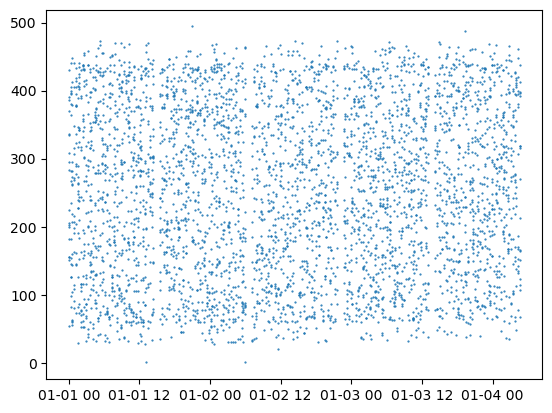

In [31]:
plt.scatter(start_times, consumable_lives, s=0.3)
plt.xlabel('Run Start Time')
plt.ylabel('Consumable Life')
plt.title('Consumable Life vs Run Start Time')
plt.show()

In [34]:
global_run_data_snap_to_seconds = global_run_data.copy()
global_run_data_snap_to_seconds['Time Stamp'] = global_run_data_snap_to_seconds['Time Stamp'].dt.round('s')

Text(0.5, 1.0, 'Distribution of Time Stamps')

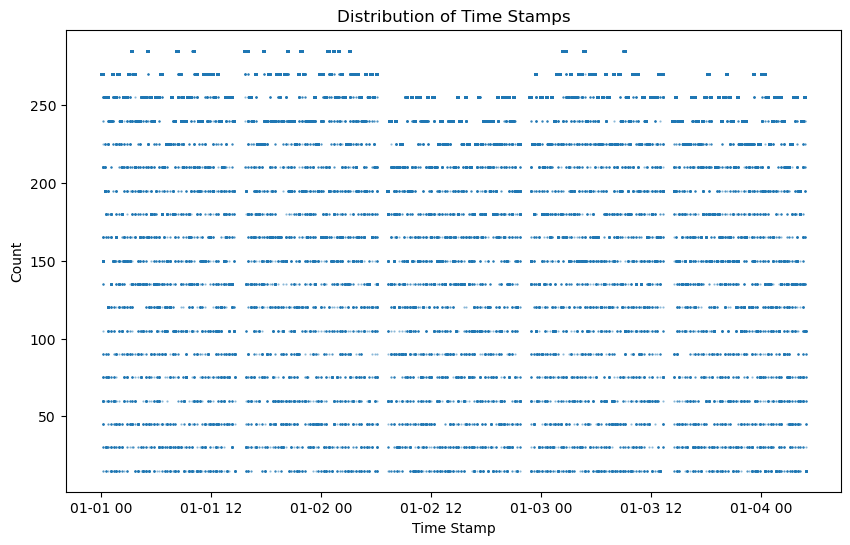

In [55]:
plt.figure(figsize=(10, 6))
counts = global_run_data_snap_to_seconds['Time Stamp'].value_counts().sort_index()
plt.scatter(counts.index, counts.values, alpha=0.5, s=0.3)
plt.xlabel('Time Stamp')
plt.ylabel('Count')
plt.title('Distribution of Time Stamps')
plt.show()

(array([18.,  0.,  0., 17.,  0.,  0.,  0., 17.,  0.,  0.,  0., 16.,  0.,
         0.,  0., 18.,  0.,  0.,  0., 17.,  0.,  0., 18.,  0.,  0.,  0.,
        16.,  0.,  0.,  0., 17.,  0.,  0.,  0., 17.,  0.,  0.,  0., 18.,
         0.,  0.,  0., 19.,  0.,  0., 18.,  0.,  0.,  0., 16.,  0.,  0.,
         0., 16.,  0.,  0.,  0., 17.,  0.,  0.,  0., 17.,  0.,  0.,  0.,
        19.,  0.,  0., 17.,  0.,  0.,  0., 16.,  0.,  0.,  0., 17.,  0.,
         0.,  0., 17.,  0.,  0.,  0., 18.,  0.,  0., 14.,  0.,  0.,  0.,
        15.,  0.,  0.,  0., 15.,  0.,  0.,  0., 17.,  0.,  0.,  0., 16.,
         0.,  0.,  0., 19.,  0.,  0., 18.,  0.,  0.,  0., 17.,  0.,  0.,
         0., 16.,  0.,  0.,  0., 17.,  0.,  0.,  0., 17.,  0.,  0.,  0.,
        19.,  0.,  0., 18.,  0.,  0.,  0., 16.,  0.,  0.,  0., 16.,  0.,
         0.,  0., 18.,  0.,  0.,  0., 18.,  0.,  0., 18.,  0.,  0.,  0.,
        18.,  0.,  0.,  0., 17.,  0.,  0.,  0., 18.,  0.,  0.,  0., 16.,
         0.,  0.,  0., 14.,  0.,  0., 17.,  0.,  0.

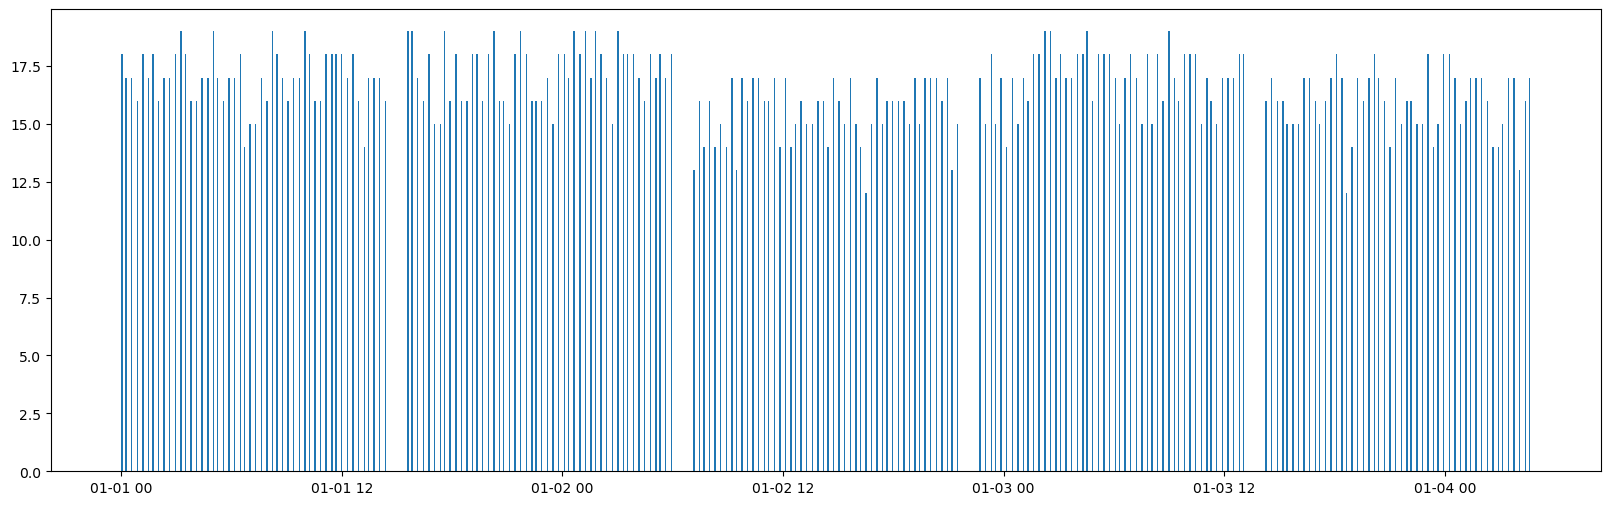

In [50]:
plt.figure(figsize=(20, 6))
plt.hist(global_run_data.groupby('Run ID')['Run Start Time'].min().values, bins=1000)